# Kaggle赛题--房价预测

## 数据预处理

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,RobustScaler
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn import linear_model

In [174]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge

In [3]:
import warnings
 
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn", lineno=245)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn", lineno=193)
#warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn", lineno=929)

In [5]:
df_train = DataFrame(pd.read_csv('train.csv'))
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [6]:
columns = df_train.columns
columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

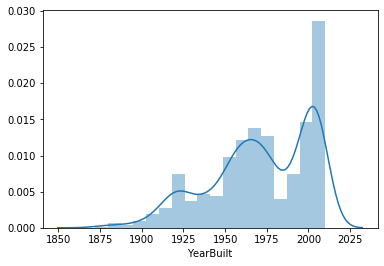

In [7]:
%matplotlib inline
sns.distplot(df_train['YearBuilt'])

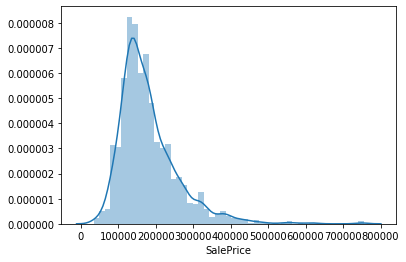

In [8]:
sns.distplot(df_train['SalePrice'])

特点：1、偏离正态分布。2、呈现正偏差（ positive skewness）。
峰度：峰度（Kurtosis）是描述某变量所有取值分布形态陡缓程度的统计量。
Kurtosis=0 与正态分布的陡缓程度相同。
Kurtosis>0 比正态分布的高峰更加陡峭——尖顶峰
Kurtosis<0 比正态分布的高峰来得平台——平顶峰

偏度：偏度（Skewness）是描述某变量取值分布对称性的统计量。
Skewness=0 分布形态与正态分布偏度相同
Skewness>0 正偏差数值较大，为正偏或右偏。长尾巴拖在右边。
Skewness<0 负偏差数值较大，为负偏或左偏。长尾巴拖在左边。

In [9]:
#居住面积和价格的关系
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data

,SalePrice,GrLivArea
0,208500,1710
1,181500,1262
2,223500,1786
3,140000,1717
4,250000,2198
...,...,...
1455,175000,1647
1456,210000,2073
1457,266500,2340
1458,142125,1078


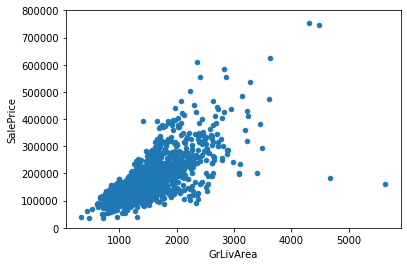

In [10]:
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

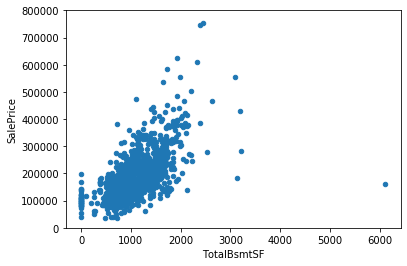

In [11]:
#地下室面积和价格的关系
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000))

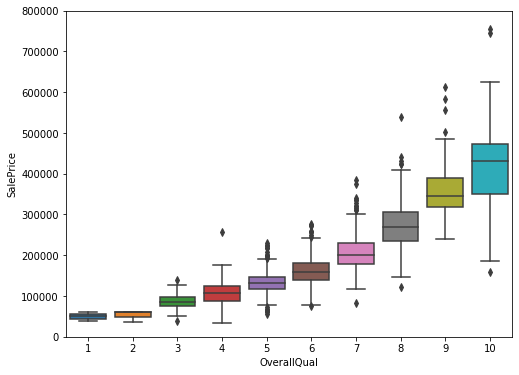

In [12]:
#整体材料和成品质量跟价格的关系（X不是连续的值，而是分为各等级的特征） 所以用的是箱线图
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis=1)
plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

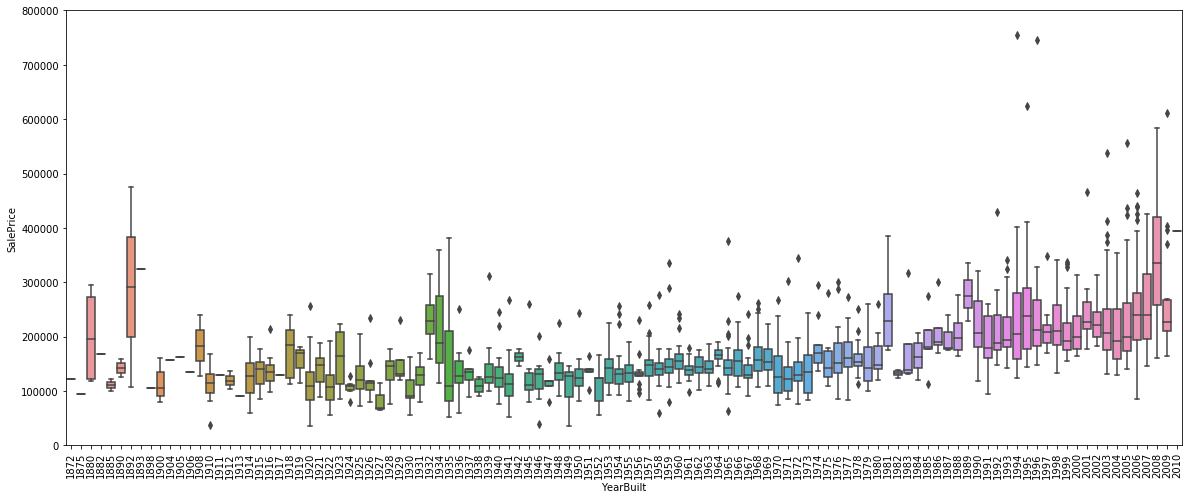

In [13]:
#建造时间和价格的关系
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

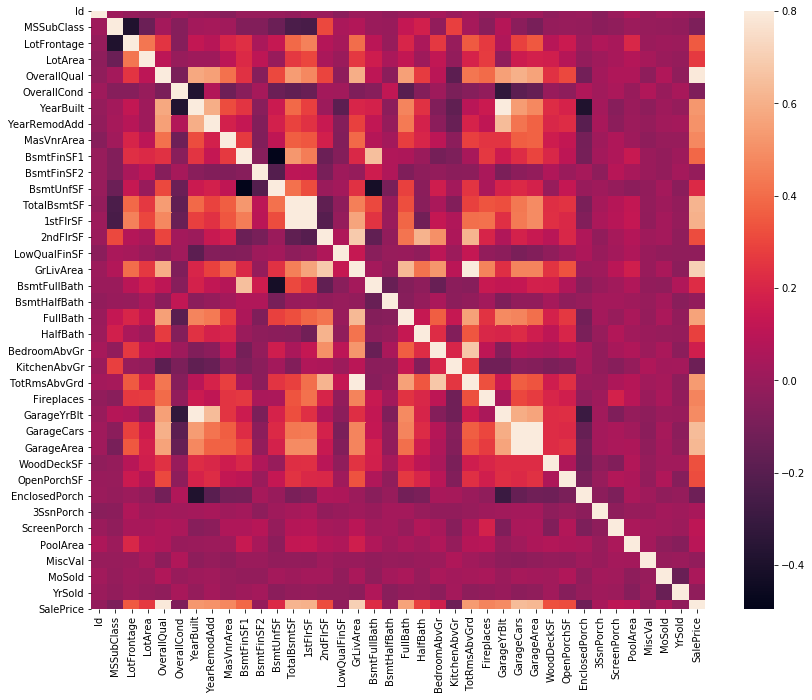

In [14]:
corrmat = df_train.corr()
plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, vmax=.8, square=True);

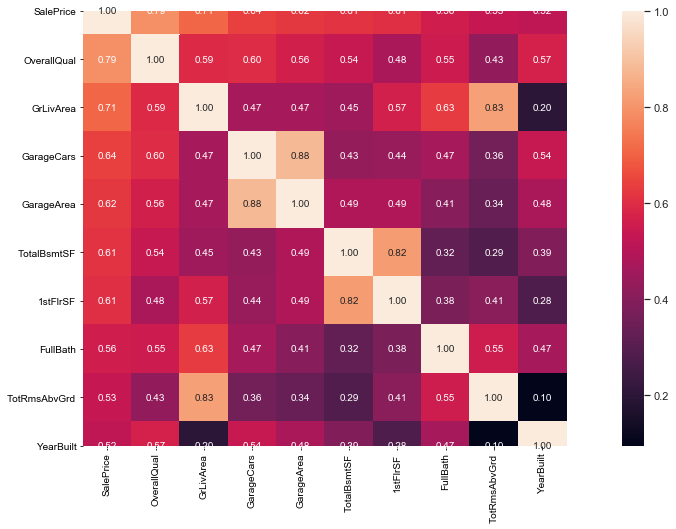

In [15]:
# 选取与价格相关的特征
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
#       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
#      dtype='object')

# 矩阵的值的转zhi，之后计算皮尔逊相关
values = df_train[cols].values.T
plt.subplots(figsize=(20, 8))

cm = np.corrcoef(values)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

根据上图，我们可以得出：
1、'OverallQual', 'GrLivArea'和'TotalBsmtSF' 特征与'SalePrice'呈强相关，跟我们之前的主观预测一样。
2、'GarageCars' 和 'GarageArea'之间的关联程度很高，其传达的信息相似，所以我们只需保留一个特征。所以我们打算保留GarageCars，因为GarageCars的分数(0.64)比GarageArea(0.62)更高。
3、'TotalBsmtSF' and '1stFloor'与第2条也是同样的道理，我们选择保留'TotalBsmtSF'。
4、'TotRmsAbvGrd' and 'GrLivArea'也是关联程度较高的两个特征，保留'GrLivArea'。

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


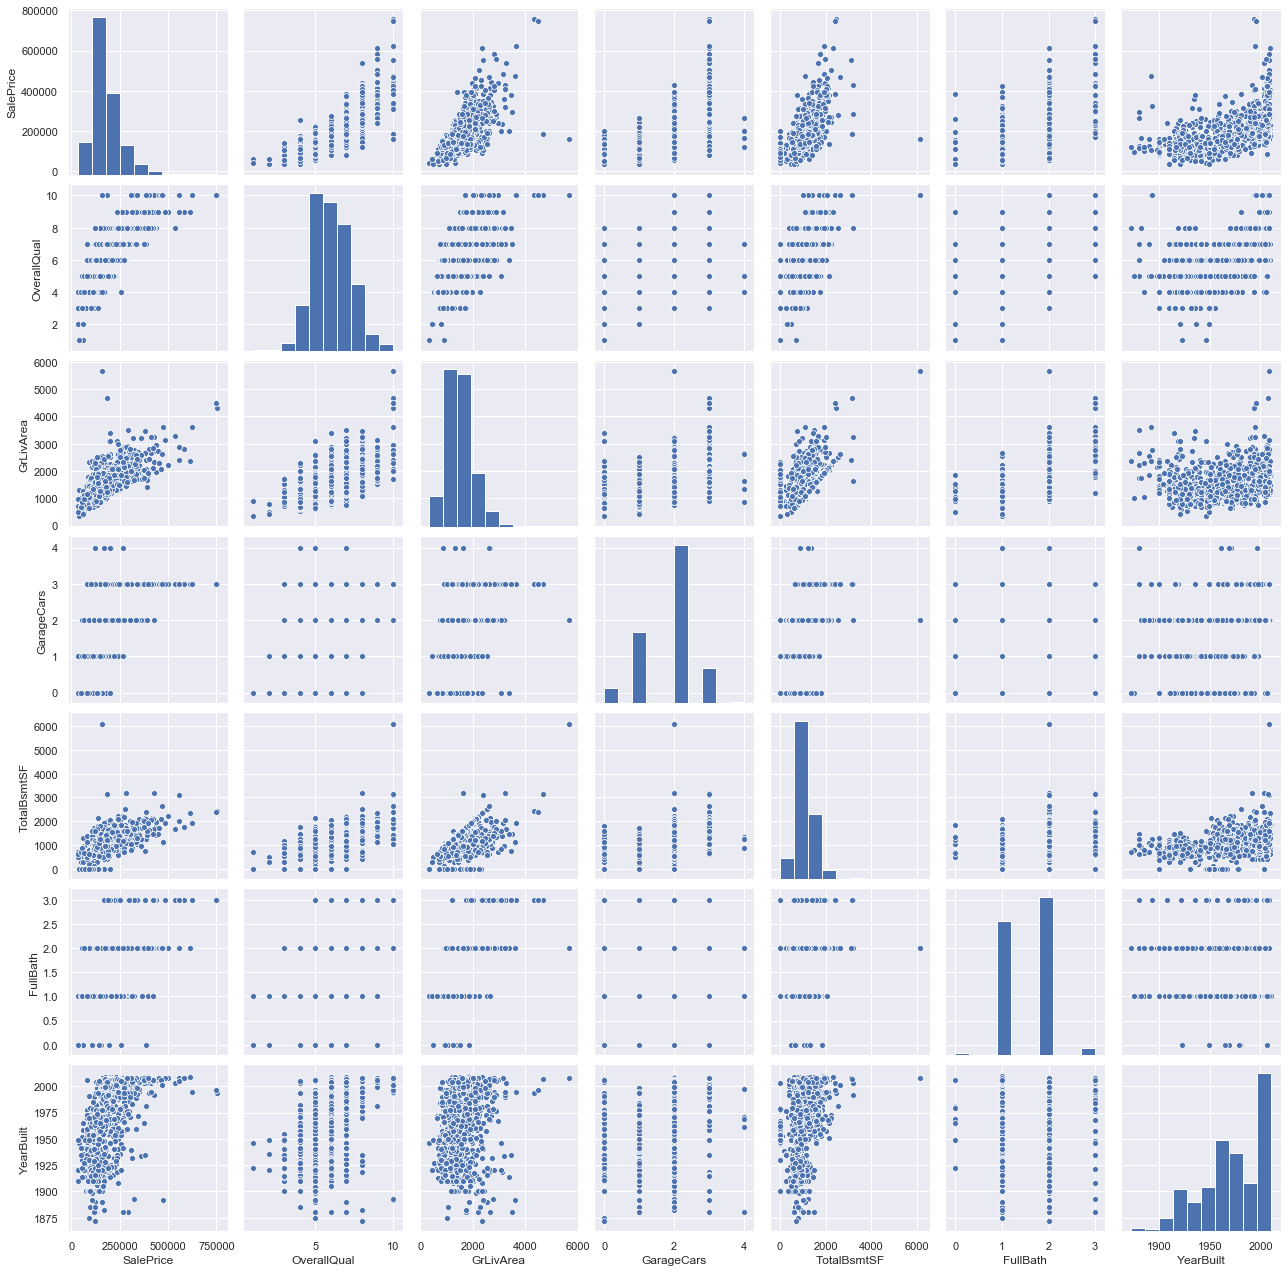

In [16]:
# 现在我们需要提取的特征有['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
# 查看特征的关系
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

In [17]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [18]:
missing_data[missing_data['Total']>1]

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


可以看到对角线上是各个属性的直方图（分布图），而非对角线上是两个不同属性之间的相关图，

In [19]:
#删除上述特征和Electrical为空的那一条记录
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #打印值应该为0，表明数据集中已没有空值

0

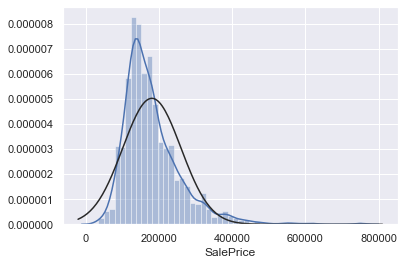

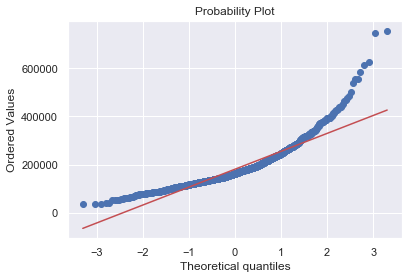

In [20]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

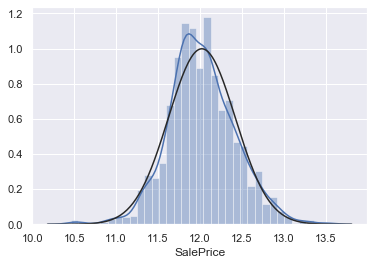

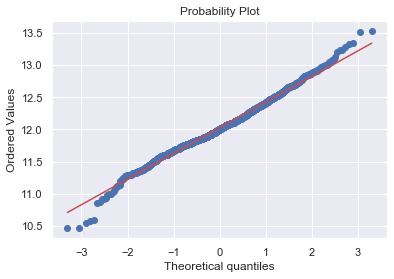

In [21]:
# 对数转换使其接近正态分布
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

接着对选取的特征做类似的对数变化 使其更接近正态分布

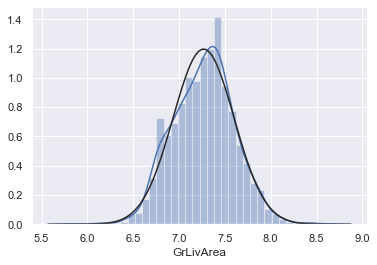

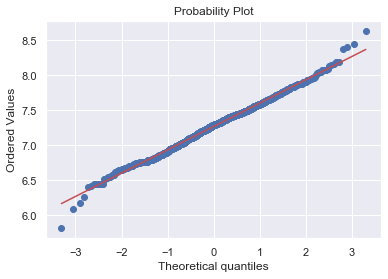

In [22]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

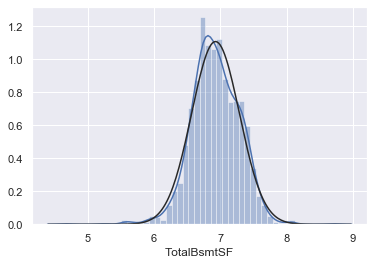

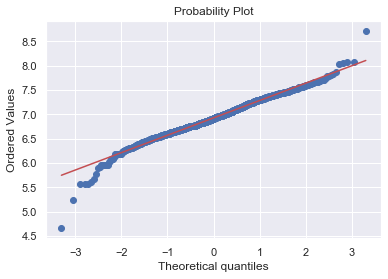

In [23]:
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'])
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

至此，完成了对训练集数据的处理，包括特征提取、对缺失数据、偏移数据进行删除，对房屋价格、居住面积、地下室面积标准化处理。
接下来进行模型的搭建。

In [101]:
#正则化取出所需的feature
train_df=df_train.filter(regex='SalePrice|OverallQual|GrLivArea|TotalBsmtSF|GarageCars|FullBath|YearBuilt')
train_up=train_df.values
print(train_df.columns)

# 展平数据和flatten区别
# 获得训练集的X和y
y=train_up[:,-1].ravel()
X=train_up[:,:-1]

print(X)
print(X.shape)
print(y)
print(len(y))

Index(['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'GarageCars', 'SalePrice'],
      dtype='object')
[[7.00000000e+00 2.00300000e+03 6.75227038e+00 ... 1.00000000e+00
  2.00000000e+00 2.00000000e+00]
 [6.00000000e+00 1.97600000e+03 7.14045304e+00 ... 0.00000000e+00
  2.00000000e+00 2.00000000e+00]
 [7.00000000e+00 2.00100000e+03 6.82437367e+00 ... 1.00000000e+00
  2.00000000e+00 2.00000000e+00]
 ...
 [7.00000000e+00 1.94100000e+03 7.04925484e+00 ... 0.00000000e+00
  2.00000000e+00 1.00000000e+00]
 [5.00000000e+00 1.95000000e+03 6.98286275e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [5.00000000e+00 1.96500000e+03 7.13568735e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
(1459, 7)
[12.24769432 12.10901093 12.31716669 ... 12.49312952 11.86446223
 11.90158345]
1459


## 模型评估方法

In [102]:
scaler = RobustScaler()
X_scale = scaler.fit(X).transform(X)#解决SVR的ConvergenceWarning



# 交叉验证
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),
          SVR(max_iter=10000),LinearSVR(max_iter=10000),ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),
          KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),ExtraTreesRegressor(),XGBRegressor()]

names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scale, y)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))



LR: 0.166066, 0.0072
Ridge: 0.166062, 0.0072
Lasso: 0.167832, 0.0082
RF: 0.166630, 0.0135
GBR: 0.155111, 0.0078
SVR: 0.157805, 0.0132


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinSVR: 0.166918, 0.0076
Ela: 0.166009, 0.0073
SGD: 0.180788, 0.0099
Bay: 0.166060, 0.0072
Ker: 0.165832, 0.0115
Extra: 0.173904, 0.0135
Xgb: 0.166477, 0.0124


In [103]:
#调参
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']]) # 取列操作
        

## 模型评估

### 训练模型与调参

#### LinearRegression

In [152]:
modelLR = LinearRegression()
scoreLR = rmse_cv(modelLR, X_scale, y)
print(scoreLR.mean())

0.16606645460778766


#### Lasso

In [154]:
LassoParams = {'alpha':[0.01, 0.005, 0.001, 0.0009, 0.0008, 0.0007, 0.0006, 0.0005, 0.0002, 0.0001], 
                  'max_iter':[10000]}
modelLasso = Lasso()
grid(modelLasso).grid_get(X_scale, y, LassoParams)

{'alpha': 0.0006, 'max_iter': 10000} 0.1661586968318483
                                 params  mean_test_score  std_test_score
0    {'alpha': 0.01, 'max_iter': 10000}         0.168031        0.002743
1   {'alpha': 0.005, 'max_iter': 10000}         0.166584        0.002544
2   {'alpha': 0.001, 'max_iter': 10000}         0.166162        0.002410
3  {'alpha': 0.0009, 'max_iter': 10000}         0.166160        0.002407
4  {'alpha': 0.0008, 'max_iter': 10000}         0.166159        0.002403
5  {'alpha': 0.0007, 'max_iter': 10000}         0.166159        0.002400
6  {'alpha': 0.0006, 'max_iter': 10000}         0.166159        0.002397
7  {'alpha': 0.0005, 'max_iter': 10000}         0.166162        0.002394
8  {'alpha': 0.0002, 'max_iter': 10000}         0.166191        0.002389
9  {'alpha': 0.0001, 'max_iter': 10000}         0.166205        0.002388


#### Ridge

In [155]:
modelRidge = Ridge()
RidgeParams = {'alpha':[35,40,45,50,55,60,65,70,80,90]}
grid(modelRidge).grid_get(X_scale, y, RidgeParams)

{'alpha': 35} 0.16658838231526865
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.166588        0.002385
1  {'alpha': 40}         0.166706        0.002391
2  {'alpha': 45}         0.166835        0.002399
3  {'alpha': 50}         0.166974        0.002407
4  {'alpha': 55}         0.167123        0.002416
5  {'alpha': 60}         0.167280        0.002426
6  {'alpha': 65}         0.167445        0.002436
7  {'alpha': 70}         0.167618        0.002447
8  {'alpha': 80}         0.167982        0.002471
9  {'alpha': 90}         0.168368        0.002497


#### RandomForestRegressor

In [105]:
cv_params = {'n_estimators':[320, 360, 400, 440, 480, 520, 560, 580, 620, 680, 720, 760]}
other_params = {'max_depth' : 5, 'min_samples_split' : 2, 'min_samples_leaf' : 1, 'min_weight_fraction_leaf':0.0,
                'max_features' : 'auto', 'min_impurity_decrease':0.0}
model = RandomForestRegressor(**other_params)
grid(model).grid_get(X_scale, y, cv_params)

{'n_estimators': 620} 0.1698519425270417
                   params  mean_test_score  std_test_score
0   {'n_estimators': 320}         0.170312        0.002649
1   {'n_estimators': 360}         0.170537        0.002682
2   {'n_estimators': 400}         0.169982        0.002907
3   {'n_estimators': 440}         0.170042        0.002799
4   {'n_estimators': 480}         0.169983        0.002811
5   {'n_estimators': 520}         0.169884        0.002831
6   {'n_estimators': 560}         0.170348        0.002784
7   {'n_estimators': 580}         0.170073        0.002800
8   {'n_estimators': 620}         0.169852        0.002759
9   {'n_estimators': 680}         0.170253        0.002810
10  {'n_estimators': 720}         0.170286        0.002833
11  {'n_estimators': 760}         0.170003        0.002817


In [106]:
cv_params = {'n_estimators':[600, 605, 610, 615, 620, 625, 630, 635, 640]}
other_params = {'max_depth' : 5, 'min_samples_split' : 2, 'min_samples_leaf' : 1, 'min_weight_fraction_leaf':0.0,
                'max_features' : 'auto', 'min_impurity_decrease':0.0}
model = RandomForestRegressor(**other_params)
grid(model).grid_get(X_scale, y, cv_params)

{'n_estimators': 630} 0.16978384096675597
                  params  mean_test_score  std_test_score
0  {'n_estimators': 600}         0.170248        0.002702
1  {'n_estimators': 605}         0.170073        0.002757
2  {'n_estimators': 610}         0.170062        0.002782
3  {'n_estimators': 615}         0.169917        0.002741
4  {'n_estimators': 620}         0.170258        0.002721
5  {'n_estimators': 625}         0.169896        0.002739
6  {'n_estimators': 630}         0.169784        0.002766
7  {'n_estimators': 635}         0.170379        0.002866
8  {'n_estimators': 640}         0.169999        0.002807


In [111]:
cv_params = {'max_depth':[3,4,5,6,7],'min_samples_split' : [2,3,4,5,6]}
other_params = {'n_estimators':630, 'min_samples_leaf' : 1, 'min_weight_fraction_leaf':0.0,
                'max_features' : 'auto', 'min_impurity_decrease':0.0}
model = RandomForestRegressor(**other_params)
grid(model).grid_get(X_scale, y, cv_params)

{'max_depth': 7, 'min_samples_split': 3} 0.1633778344897391
                                      params  mean_test_score  std_test_score
0   {'max_depth': 3, 'min_samples_split': 2}         0.197492        0.002475
1   {'max_depth': 3, 'min_samples_split': 3}         0.197605        0.002467
2   {'max_depth': 3, 'min_samples_split': 4}         0.197616        0.002444
3   {'max_depth': 3, 'min_samples_split': 5}         0.197662        0.002427
4   {'max_depth': 3, 'min_samples_split': 6}         0.197583        0.002474
5   {'max_depth': 4, 'min_samples_split': 2}         0.179491        0.002302
6   {'max_depth': 4, 'min_samples_split': 3}         0.179958        0.002364
7   {'max_depth': 4, 'min_samples_split': 4}         0.179543        0.002401
8   {'max_depth': 4, 'min_samples_split': 5}         0.179835        0.002306
9   {'max_depth': 4, 'min_samples_split': 6}         0.179639        0.002382
10  {'max_depth': 5, 'min_samples_split': 2}         0.169983        0.002748
11  

In [112]:
cv_params = {'min_weight_fraction_leaf':np.linspace(0, 0.01, 10, endpoint = True).tolist(), 'min_impurity_decrease':np.linspace(0, 0.01, 10, endpoint = True).tolist()}
other_params = {'max_depth': 7,'n_estimators':585, 'min_samples_split': 3,'min_weight_fraction_leaf':0.0,
                'min_samples_leaf' : 2, 'max_features' : 'auto'}
model = RandomForestRegressor(**other_params)
grid(model).grid_get(X_scale, y, cv_params)

{'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0} 0.1626017294793968
                                               params  mean_test_score  \
0   {'min_impurity_decrease': 0.0, 'min_weight_fra...         0.162602   
1   {'min_impurity_decrease': 0.0, 'min_weight_fra...         0.162700   
2   {'min_impurity_decrease': 0.0, 'min_weight_fra...         0.162962   
3   {'min_impurity_decrease': 0.0, 'min_weight_fra...         0.162923   
4   {'min_impurity_decrease': 0.0, 'min_weight_fra...         0.163301   
..                                                ...              ...   
95  {'min_impurity_decrease': 0.01, 'min_weight_fr...         0.235573   
96  {'min_impurity_decrease': 0.01, 'min_weight_fr...         0.235472   
97  {'min_impurity_decrease': 0.01, 'min_weight_fr...         0.235447   
98  {'min_impurity_decrease': 0.01, 'min_weight_fr...         0.235266   
99  {'min_impurity_decrease': 0.01, 'min_weight_fr...         0.235482   

    std_test_score  
0      

In [113]:
params = {'max_depth': 7,'n_estimators':360, 'min_samples_split': 3,'min_weight_fraction_leaf':0.0,
          'min_samples_leaf' : 2, 'max_features' : 'auto','min_impurity_decrease': 0.0,
          'min_weight_fraction_leaf': 0.0}
model = RandomForestRegressor(**params)
model.fit(X_scale, y)
# print(model.feature_importances_)
# print(list(train_df.columns))
score_list = []
columnsList = list(train_df.columns).copy()
print(columnsList)
for i in range(len(columnsList)-1):
    score_list.append((columnsList[i], model.feature_importances_[i]))
    
def takeSecond(elem):
    return elem[1]
print('特征重要性排名：')
res = sorted(score_list, key = takeSecond, reverse = True)

print(res)

['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'GarageCars', 'SalePrice']
特征重要性排名：
[('OverallQual', 0.6318326942157412), ('GrLivArea', 0.15019128946006807), ('TotalBsmtSF', 0.09029131894986149), ('GarageCars', 0.06587317516683838), ('YearBuilt', 0.05052446127332876), ('BsmtFullBath', 0.0075948799673135805), ('FullBath', 0.0036921809668485086)]


**获得RandomForest调参后，选择的参数有：**

'max_depth': 7,'n_estimators':360, 'min_samples_split': 3,'min_weight_fraction_leaf':0.0,
'min_samples_leaf' : 2, 'max_features' : 'auto','min_impurity_decrease': 0.0,
'min_weight_fraction_leaf': 0.0

**得到特征重要性排名：**
1. OverallQual
2. GrLivArea
3. TotalBsmtSF
4. GarageCars
5. YearBuilt
6. BsmtFullBath
7. FullBath

**结果:**
0.162602 0.002995

#### SVR

In [122]:
cv_params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma':['scale', 'auto'], 'degree':[2,3,4]}
other_params = {'degree':3, 'gamma':'scale', 'coef0':0.0, 'C':1.0}
model = SVR(**other_params)
grid(model).grid_get(X_scale, y, cv_params)

{'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'} 0.15769497853018263
                                               params  mean_test_score  \
0   {'degree': 2, 'gamma': 'scale', 'kernel': 'lin...         0.166452   
1   {'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}         0.256393   
2    {'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}         0.157695   
3   {'degree': 2, 'gamma': 'scale', 'kernel': 'sig...        53.958352   
4   {'degree': 2, 'gamma': 'auto', 'kernel': 'line...         0.166452   
5    {'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}         0.257631   
6     {'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}         0.158358   
7   {'degree': 2, 'gamma': 'auto', 'kernel': 'sigm...        58.487913   
8   {'degree': 3, 'gamma': 'scale', 'kernel': 'lin...         0.166452   
9   {'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}         0.268375   
10   {'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}         0.157695   
11  {'degree': 3, 'gamma': 'scale', 'kernel

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [123]:
cv_params = {'C':np.linspace(0.5, 1.5, 5, endpoint = True)}
other_params = {'kernel':'rbf','gamma':'scale'}
model = SVR(**other_params)
grid(model).grid_get(X_scale, y, cv_params)

{'C': 0.75} 0.1572340234281959
        params  mean_test_score  std_test_score
0   {'C': 0.5}         0.157761        0.003440
1  {'C': 0.75}         0.157234        0.003639
2   {'C': 1.0}         0.157695        0.004042
3  {'C': 1.25}         0.158119        0.004353
4   {'C': 1.5}         0.158215        0.004425


**获得SVR调参后，选择的参数有：**

'kernel': 'rbf,'gamma':'scale', 'C': 0.75'

**结果：**
0.157234 0.003639

#### GBR

In [128]:
cv_params = {'loss': ['ls', 'lad', 'huber', 'quantile']}
other_params = {'learning_rate':0.1, 'n_estimators':100, 'max_depth':3, 'min_samples_split':2,
               'min_samples_leaf':1, 'min_weight_fraction_leaf':0, 'subsample':1, 'max_features':None,
               'max_leaf_nodes':None, 'alpha':0.9,  }
model = GradientBoostingRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'loss': 'huber'} 0.15327820401042092
                 params  mean_test_score  std_test_score
0        {'loss': 'ls'}         0.155718        0.002576
1       {'loss': 'lad'}         0.157637        0.003133
2     {'loss': 'huber'}         0.153278        0.003145
3  {'loss': 'quantile'}         0.245324        0.006750


In [140]:
cv_params = {'n_estimators': [80, 90, 100,110,120,130,140,150,160,300,400,500]}
other_params = {'loss':'huber', 'learning_rate':0.1,'max_depth':3, 'min_samples_split':2,
                   'min_samples_leaf':1, 'min_weight_fraction_leaf':0., 'subsample':1, 'max_features':None,
                   'max_leaf_nodes':None, 'alpha':0.9 }
model = GradientBoostingRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'n_estimators': 100} 0.15349505144211015
                   params  mean_test_score  std_test_score
0    {'n_estimators': 80}         0.153683        0.002782
1    {'n_estimators': 90}         0.153774        0.002799
2   {'n_estimators': 100}         0.153495        0.003068
3   {'n_estimators': 110}         0.153632        0.002840
4   {'n_estimators': 120}         0.153656        0.002846
5   {'n_estimators': 130}         0.154296        0.003240
6   {'n_estimators': 140}         0.154270        0.003481
7   {'n_estimators': 150}         0.154045        0.003315
8   {'n_estimators': 160}         0.154651        0.003184
9   {'n_estimators': 300}         0.156623        0.003274
10  {'n_estimators': 400}         0.160019        0.004030
11  {'n_estimators': 500}         0.161552        0.004225


In [141]:
cv_params = {'max_depth':[3,4,5,6,7]}
other_params = {'loss':'huber','n_estimators': 100, 'learning_rate':0.1, 'min_samples_split':2,
                   'min_samples_leaf':1, 'min_weight_fraction_leaf':0., 'subsample':1, 'max_features':None,
                   'max_leaf_nodes':None, 'alpha':0.9 }
model = GradientBoostingRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'max_depth': 3} 0.15376542851336067
             params  mean_test_score  std_test_score
0  {'max_depth': 3}         0.153765        0.003014
1  {'max_depth': 4}         0.156588        0.003173
2  {'max_depth': 5}         0.158605        0.003447
3  {'max_depth': 6}         0.161549        0.003911
4  {'max_depth': 7}         0.166783        0.003172


In [142]:
cv_params = {'min_samples_split':[2,3,4,5],'min_samples_leaf':[1,5,10,15], 
             'min_weight_fraction_leaf':[0.1, 0.2, .03, .4, .5]}
other_params = {'loss':'huber','n_estimators': 100, 'learning_rate':0.1,'max_depth':3, 'subsample':1, 'max_features':None,
                   'max_leaf_nodes':None, 'alpha':0.9 }
model = GradientBoostingRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.03} 0.15845636835300395
                                               params  mean_test_score  \
0   {'min_samples_leaf': 1, 'min_samples_split': 2...         0.168577   
1   {'min_samples_leaf': 1, 'min_samples_split': 2...         0.184979   
2   {'min_samples_leaf': 1, 'min_samples_split': 2...         0.158456   
3   {'min_samples_leaf': 1, 'min_samples_split': 2...         0.223974   
4   {'min_samples_leaf': 1, 'min_samples_split': 2...         0.389011   
..                                                ...              ...   
75  {'min_samples_leaf': 15, 'min_samples_split': ...         0.168577   
76  {'min_samples_leaf': 15, 'min_samples_split': ...         0.184979   
77  {'min_samples_leaf': 15, 'min_samples_split': ...         0.158456   
78  {'min_samples_leaf': 15, 'min_samples_split': ...         0.223974   
79  {'min_samples_leaf': 15, 'min_samples_split': ...         0.389011   

    std_t

In [149]:
cv_params = {'subsample':[0.6, 0.7, 0.8, 0.9,1]}
other_params = {'loss':'huber','n_estimators': 100,'min_samples_leaf':1, 'min_samples_split':2,
                'learning_rate':0.1,'max_depth':3,'min_weight_fraction_leaf':0,'max_leaf_nodes':None, 'alpha':0.9 }
model = GradientBoostingRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'subsample': 1} 0.15300655654845202
               params  mean_test_score  std_test_score
0  {'subsample': 0.6}         0.155226        0.002826
1  {'subsample': 0.7}         0.154596        0.003008
2  {'subsample': 0.8}         0.153113        0.002710
3  {'subsample': 0.9}         0.154052        0.003085
4    {'subsample': 1}         0.153007        0.002876


In [150]:
cv_params = {'min_weight_fraction_leaf':[0., 0.05, 0.1, 0.15, 0.2]}
other_params = {'loss':'huber','n_estimators': 100,'min_samples_leaf':1, 'min_samples_split':2,
                'learning_rate':0.1,'max_depth':3,'min_weight_fraction_leaf':0,'max_leaf_nodes':None, 'alpha':0.9 }
model = GradientBoostingRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'min_weight_fraction_leaf': 0.0} 0.1531309520294358
                               params  mean_test_score  std_test_score
0   {'min_weight_fraction_leaf': 0.0}         0.153131        0.002811
1  {'min_weight_fraction_leaf': 0.05}         0.159695        0.001890
2   {'min_weight_fraction_leaf': 0.1}         0.168577        0.001409
3  {'min_weight_fraction_leaf': 0.15}         0.173731        0.002070
4   {'min_weight_fraction_leaf': 0.2}         0.184979        0.002299


In [151]:
cv_params = {'alpha':[0.8, 0.85, 0.9, 0.95]}
other_params = {'loss':'huber','n_estimators': 100,'min_samples_leaf':1, 'min_samples_split':2,
                'learning_rate':0.1,'max_depth':3, 'alpha':0.9 }
model = GradientBoostingRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'alpha': 0.9} 0.1531649013224712
            params  mean_test_score  std_test_score
0   {'alpha': 0.8}         0.153274        0.003038
1  {'alpha': 0.85}         0.154087        0.003255
2   {'alpha': 0.9}         0.153165        0.002855
3  {'alpha': 0.95}         0.155630        0.002994


调整GBR参数后最有结果参数为：'loss':'huber','n_estimators': 100,'min_samples_leaf':1, 'min_samples_split':2,
                'learning_rate':0.1,'max_depth':3, 'alpha':0.9

**结果为：**
0.153165        0.002855

#### LinSVR

In [182]:
cv_params = {'max_iter' : range(10000, 100000, 5000)}
model = LinearSVR()
grid(model).grid_get(X_scale, y, {'max_iter' : range(10000,100000, 5000)})

{'max_iter': 25000} 0.16703985757353454
                 params  mean_test_score  std_test_score
0   {'max_iter': 10000}         0.167062        0.002502
1   {'max_iter': 15000}         0.167080        0.002517
2   {'max_iter': 20000}         0.167096        0.002519
3   {'max_iter': 25000}         0.167040        0.002497
4   {'max_iter': 30000}         0.167080        0.002523
5   {'max_iter': 35000}         0.167074        0.002493
6   {'max_iter': 40000}         0.167100        0.002521
7   {'max_iter': 45000}         0.167122        0.002529
8   {'max_iter': 50000}         0.167079        0.002510
9   {'max_iter': 55000}         0.167164        0.002516
10  {'max_iter': 60000}         0.167104        0.002508
11  {'max_iter': 65000}         0.167100        0.002520
12  {'max_iter': 70000}         0.167100        0.002515
13  {'max_iter': 75000}         0.167180        0.002517
14  {'max_iter': 80000}         0.167168        0.002514
15  {'max_iter': 85000}         0.167135        

In [187]:
cv_params = {'epsilon' : np.arange(0, 0.2, 0.01)}
other_params = {'max_iter' : 45000}
model = LinearSVR(**other_params)
grid(model).grid_get(X_scale,y,{'epsilon' : np.arange(0, 0.2, 0.01)})

{'epsilon': 0.15} 0.1661542013764409
               params  mean_test_score  std_test_score
0    {'epsilon': 0.0}         0.167128        0.002532
1   {'epsilon': 0.01}         0.167036        0.002518
2   {'epsilon': 0.02}         0.167292        0.002555
3   {'epsilon': 0.03}         0.167110        0.002536
4   {'epsilon': 0.04}         0.167001        0.002498
5   {'epsilon': 0.05}         0.167046        0.002511
6   {'epsilon': 0.06}         0.166724        0.002457
7   {'epsilon': 0.07}         0.166663        0.002437
8   {'epsilon': 0.08}         0.166651        0.002440
9   {'epsilon': 0.09}         0.166407        0.002433
10   {'epsilon': 0.1}         0.166590        0.002457
11  {'epsilon': 0.11}         0.166362        0.002402
12  {'epsilon': 0.12}         0.166409        0.002381
13  {'epsilon': 0.13}         0.166389        0.002378
14  {'epsilon': 0.14}         0.166357        0.002375
15  {'epsilon': 0.15}         0.166154        0.002323
16  {'epsilon': 0.16}       

LinSVR调参后选择的参数：'max_iter' : 45000, 'epsilon' : 0.15 

**结果：**
0.166154

#### ELA

In [188]:
model = ElasticNet()
grid(model).grid_get(X_scale,y,{'alpha' : np.arange(0.0002, 0.002, 0.0002)})

{'alpha': 0.0012000000000000001} 0.16616210996327382
                             params  mean_test_score  std_test_score
0                 {'alpha': 0.0002}         0.166204        0.002388
1                 {'alpha': 0.0004}         0.166190        0.002388
2  {'alpha': 0.0006000000000000001}         0.166177        0.002389
3                 {'alpha': 0.0008}         0.166169        0.002391
4                  {'alpha': 0.001}         0.166163        0.002394
5  {'alpha': 0.0012000000000000001}         0.166162        0.002397
6  {'alpha': 0.0014000000000000002}         0.166163        0.002400
7                 {'alpha': 0.0016}         0.166165        0.002404
8  {'alpha': 0.0018000000000000002}         0.166167        0.002407


In [189]:
other_params = {'alpha': 0.0012}
model = ElasticNet(**other_params)
grid(model).grid_get(X_scale,y,{'l1_ratio' : np.arange(0.1, 1, 0.1)})

{'l1_ratio': 0.6} 0.16616182458355613
                              params  mean_test_score  std_test_score
0                  {'l1_ratio': 0.1}         0.166197        0.002386
1                  {'l1_ratio': 0.2}         0.166182        0.002387
2  {'l1_ratio': 0.30000000000000004}         0.166172        0.002390
3                  {'l1_ratio': 0.4}         0.166164        0.002393
4                  {'l1_ratio': 0.5}         0.166162        0.002397
5                  {'l1_ratio': 0.6}         0.166162        0.002401
6   {'l1_ratio': 0.7000000000000001}         0.166162        0.002405
7                  {'l1_ratio': 0.8}         0.166163        0.002409
8                  {'l1_ratio': 0.9}         0.166164        0.002413


Ela调参后选择的参数为：'alpha' : 0.0012, 'l1_ratio' : 0.6

#### SGD

In [190]:
other_params = {'l1_ratio' : 0.15, 'tol' : 1e-3, 'max_iter' : 20000}
model = SGDRegressor(**other_params)
grid(model).grid_get(X_scale,y, {'alpha':np.arange(0.01, 0.2, 0.01)})

{'alpha': 0.08} 0.16835713824579732
                             params  mean_test_score  std_test_score
0                   {'alpha': 0.01}         0.176485        0.003705
1                   {'alpha': 0.02}         0.174019        0.003332
2                   {'alpha': 0.03}         0.172443        0.003159
3                   {'alpha': 0.04}         0.169997        0.003004
4                   {'alpha': 0.05}         0.169331        0.002928
5   {'alpha': 0.060000000000000005}         0.168840        0.002854
6    {'alpha': 0.06999999999999999}         0.168521        0.002828
7                   {'alpha': 0.08}         0.168357        0.002952
8                   {'alpha': 0.09}         0.168644        0.002963
9    {'alpha': 0.09999999999999999}         0.168643        0.002906
10                  {'alpha': 0.11}         0.168640        0.002842
11                  {'alpha': 0.12}         0.169172        0.002809
12                  {'alpha': 0.13}         0.169676        0.00292

In [191]:
other_params = {'alpha' : 0.08, 'tol' : 1e-3, 'max_iter' : 20000}
model = SGDRegressor(**other_params)
grid(model).grid_get(X_scale,y, {'l1_ratio':np.arange(0.1, 1, 0.1)})

{'l1_ratio': 0.4} 0.16770770139489152
                              params  mean_test_score  std_test_score
0                  {'l1_ratio': 0.1}         0.168332        0.002843
1                  {'l1_ratio': 0.2}         0.168951        0.002812
2  {'l1_ratio': 0.30000000000000004}         0.168182        0.002831
3                  {'l1_ratio': 0.4}         0.167708        0.002693
4                  {'l1_ratio': 0.5}         0.168242        0.002821
5                  {'l1_ratio': 0.6}         0.168592        0.002888
6   {'l1_ratio': 0.7000000000000001}         0.168524        0.002914
7                  {'l1_ratio': 0.8}         0.168129        0.002763
8                  {'l1_ratio': 0.9}         0.168357        0.002823


In [192]:
other_params = {'alpha' : 0.08, 'l1_ratio' : 0.3, 'max_iter' : 20000}
model = SGDRegressor(**other_params)
grid(model).grid_get(X_scale,y,{'tol' : [1e-5, 1e-4, 1e-3, 1e-2]})

{'tol': 1e-05} 0.16789399696425047
            params  mean_test_score  std_test_score
0   {'tol': 1e-05}         0.167894        0.002598
1  {'tol': 0.0001}         0.168084        0.002661
2   {'tol': 0.001}         0.168442        0.002635
3    {'tol': 0.01}         0.177407        0.003345


In [40]:
cv_params = {'alpha_1':[1e-5,1e-6,1e-7],'lambda_1':[1e-5,1e-6,1e-7]}
other_params = {'alpha_2':1e-6,'lambda_2':1e-6}
model = BayesianRidge(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'alpha_1': 1e-07, 'lambda_1': 1e-05} 0.16621305186097615
                                  params  mean_test_score  std_test_score
0  {'alpha_1': 1e-05, 'lambda_1': 1e-05}         0.166213        0.002385
1  {'alpha_1': 1e-05, 'lambda_1': 1e-06}         0.166213        0.002385
2  {'alpha_1': 1e-05, 'lambda_1': 1e-07}         0.166213        0.002385
3  {'alpha_1': 1e-06, 'lambda_1': 1e-05}         0.166213        0.002385
4  {'alpha_1': 1e-06, 'lambda_1': 1e-06}         0.166213        0.002385
5  {'alpha_1': 1e-06, 'lambda_1': 1e-07}         0.166213        0.002385
6  {'alpha_1': 1e-07, 'lambda_1': 1e-05}         0.166213        0.002385
7  {'alpha_1': 1e-07, 'lambda_1': 1e-06}         0.166213        0.002385
8  {'alpha_1': 1e-07, 'lambda_1': 1e-07}         0.166213        0.002385


In [193]:
other_params = {'alpha' : 0.08, 'l1_ratio' : 0.3, 'tol' : 1e-4}
model = SGDRegressor(**other_params)
grid(model).grid_get(X_scale,y,{'max_iter' : range(10000, 100000, 10000)})

{'max_iter': 80000} 0.16736024550110312
                params  mean_test_score  std_test_score
0  {'max_iter': 10000}         0.167692        0.002641
1  {'max_iter': 20000}         0.167922        0.002776
2  {'max_iter': 30000}         0.168124        0.002767
3  {'max_iter': 40000}         0.167378        0.002577
4  {'max_iter': 50000}         0.167665        0.002577
5  {'max_iter': 60000}         0.167955        0.002781
6  {'max_iter': 70000}         0.167900        0.002522
7  {'max_iter': 80000}         0.167360        0.002598
8  {'max_iter': 90000}         0.167895        0.002656


SGD调参结果：'alpha' : 0.08, 'l1_ratio' : 0.3, 'tol' : 1e-4, 'max_iter' : 10000

#### BayesianRidge

In [234]:
cv_params = {'alpha_1':[1e-5,1e-6,1e-7],'lambda_1':[1e-5,1e-6,1e-7]}
other_params = {'alpha_2':1e-6,'lambda_2':1e-6}
model = BayesianRidge(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'alpha_1': 1e-07, 'lambda_1': 1e-05} 0.1662130518609762
                                  params  mean_test_score  std_test_score
0  {'alpha_1': 1e-05, 'lambda_1': 1e-05}         0.166213        0.002385
1  {'alpha_1': 1e-05, 'lambda_1': 1e-06}         0.166213        0.002385
2  {'alpha_1': 1e-05, 'lambda_1': 1e-07}         0.166213        0.002385
3  {'alpha_1': 1e-06, 'lambda_1': 1e-05}         0.166213        0.002385
4  {'alpha_1': 1e-06, 'lambda_1': 1e-06}         0.166213        0.002385
5  {'alpha_1': 1e-06, 'lambda_1': 1e-07}         0.166213        0.002385
6  {'alpha_1': 1e-07, 'lambda_1': 1e-05}         0.166213        0.002385
7  {'alpha_1': 1e-07, 'lambda_1': 1e-06}         0.166213        0.002385
8  {'alpha_1': 1e-07, 'lambda_1': 1e-07}         0.166213        0.002385


In [235]:
cv_params = {'alpha_2':[1e-5,1e-6,1e-7],'lambda_2':[1e-5,1e-6,1e-7]}
other_params = {'alpha_1':1e-7,'lambda_1':1e-5}
model = BayesianRidge(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'alpha_2': 1e-05, 'lambda_2': 1e-07} 0.16621305179677415
                                  params  mean_test_score  std_test_score
0  {'alpha_2': 1e-05, 'lambda_2': 1e-05}         0.166213        0.002385
1  {'alpha_2': 1e-05, 'lambda_2': 1e-06}         0.166213        0.002385
2  {'alpha_2': 1e-05, 'lambda_2': 1e-07}         0.166213        0.002385
3  {'alpha_2': 1e-06, 'lambda_2': 1e-05}         0.166213        0.002385
4  {'alpha_2': 1e-06, 'lambda_2': 1e-06}         0.166213        0.002385
5  {'alpha_2': 1e-06, 'lambda_2': 1e-07}         0.166213        0.002385
6  {'alpha_2': 1e-07, 'lambda_2': 1e-05}         0.166213        0.002385
7  {'alpha_2': 1e-07, 'lambda_2': 1e-06}         0.166213        0.002385
8  {'alpha_2': 1e-07, 'lambda_2': 1e-07}         0.166213        0.002385


BayesianRidge参数：{'alpha_1': 1e-07, 'lambda_1': 1e-05,'alpha_2': 1e-05, 'lambda_2': 1e-07} 

#### Kernel Ridge

In [46]:
cv_params = {'alpha':[0.2,0.3,0.4,0.5]}
other_params = {'kernel':"polynomial", 'degree':3,'coef0':0.8}
model = KernelRidge(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'alpha': 0.3} 0.1644709782777276
           params  mean_test_score  std_test_score
0  {'alpha': 0.2}         0.164575        0.005194
1  {'alpha': 0.3}         0.164471        0.005157
2  {'alpha': 0.4}         0.164858        0.005133
3  {'alpha': 0.5}         0.165557        0.005115


In [48]:
cv_params = {'coef0':[0.8,1,1.2]}
other_params = {'alpha': 0.3,'kernel':"polynomial", 'degree':3}
model = KernelRidge(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'coef0': 1} 0.16401296397609227
           params  mean_test_score  std_test_score
0  {'coef0': 0.8}         0.164471        0.005157
1    {'coef0': 1}         0.164013        0.005181
2  {'coef0': 1.2}         0.164080        0.005216


KernelRidge:{'alpha': 0.3,'kernel':"polynomial", 'degree':3,'coef0': 1}

#### XGBRegressor

In [125]:
cv_params = {'n_estimators':[220, 240, 260 ,280, 300,320,340, 360]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'n_estimators': 220} 0.1587993139916319
                  params  mean_test_score  std_test_score
0  {'n_estimators': 220}         0.158799        0.003868
1  {'n_estimators': 240}         0.159127        0.004008
2  {'n_estimators': 260}         0.160027        0.004094
3  {'n_estimators': 280}         0.160351        0.004137
4  {'n_estimators': 300}         0.161078        0.004171
5  {'n_estimators': 320}         0.161504        0.004245
6  {'n_estimators': 340}         0.161984        0.004198
7  {'n_estimators': 360}         0.162426        0.004189


In [126]:
cv_params = {'n_estimators': [300, 325, 350, 375, 400,425,450]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBRegressor(**other_params)
grid(model).grid_get(X_scale,y,{'n_estimators': [425,450,475,500,525]})

{'n_estimators': 425} 0.16361279043096127
                  params  mean_test_score  std_test_score
0  {'n_estimators': 425}         0.163613        0.004228
1  {'n_estimators': 450}         0.163906        0.004185
2  {'n_estimators': 475}         0.164200        0.004235
3  {'n_estimators': 500}         0.164536        0.004255
4  {'n_estimators': 525}         0.164790        0.004262


In [127]:
cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 425, 'seed': 0,
                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'max_depth': 3, 'min_child_weight': 2} 0.15610097589392977
                                      params  mean_test_score  std_test_score
0    {'max_depth': 3, 'min_child_weight': 1}         0.158733        0.003453
1    {'max_depth': 3, 'min_child_weight': 2}         0.156101        0.002750
2    {'max_depth': 3, 'min_child_weight': 3}         0.158080        0.003146
3    {'max_depth': 3, 'min_child_weight': 4}         0.160415        0.003241
4    {'max_depth': 3, 'min_child_weight': 5}         0.160247        0.003542
5    {'max_depth': 3, 'min_child_weight': 6}         0.162280        0.003630
6    {'max_depth': 4, 'min_child_weight': 1}         0.162620        0.003865
7    {'max_depth': 4, 'min_child_weight': 2}         0.160130        0.003137
8    {'max_depth': 4, 'min_child_weight': 3}         0.162283        0.003632
9    {'max_depth': 4, 'min_child_weight': 4}         0.161526        0.003070
10   {'max_depth': 4, 'min_child_weight': 5}         0.163063        0.003664
11  

In [62]:
cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
other_params = {'learning_rate': 0.1,'n_estimators': 425,'seed': 0,'max_depth': 3,'min_child_weight': 2,'subsample': 0.8,
                'colsample_bytree': 0.8,'reg_alpha': 0,'reg_lambda': 1}
model = XGBRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'gamma': 0.1} 0.1553742154224209
           params  mean_test_score  std_test_score
0  {'gamma': 0.1}         0.155374        0.001777
1  {'gamma': 0.2}         0.156599        0.001938
2  {'gamma': 0.3}         0.158385        0.001866
3  {'gamma': 0.4}         0.160065        0.002072
4  {'gamma': 0.5}         0.162022        0.002080
5  {'gamma': 0.6}         0.163657        0.002057


In [64]:
cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9],'colsample_bytree':[0.6, 0.7, 0.8, 0.9]}
other_params = {'learning_rate': 0.1,'n_estimators': 425,'seed': 0,'max_depth': 3,'min_child_weight': 2,
                'gamma': '0.155374','reg_alpha': 0,'reg_lambda': 1}
model = XGBRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'colsample_bytree': 0.9, 'subsample': 0.6} 0.15469828473710687
                                         params  mean_test_score  \
0   {'colsample_bytree': 0.6, 'subsample': 0.6}         0.155951   
1   {'colsample_bytree': 0.6, 'subsample': 0.7}         0.156699   
2   {'colsample_bytree': 0.6, 'subsample': 0.8}         0.157655   
3   {'colsample_bytree': 0.6, 'subsample': 0.9}         0.157145   
4   {'colsample_bytree': 0.7, 'subsample': 0.6}         0.155951   
5   {'colsample_bytree': 0.7, 'subsample': 0.7}         0.156699   
6   {'colsample_bytree': 0.7, 'subsample': 0.8}         0.157655   
7   {'colsample_bytree': 0.7, 'subsample': 0.9}         0.157145   
8   {'colsample_bytree': 0.8, 'subsample': 0.6}         0.155877   
9   {'colsample_bytree': 0.8, 'subsample': 0.7}         0.156406   
10  {'colsample_bytree': 0.8, 'subsample': 0.8}         0.155860   
11  {'colsample_bytree': 0.8, 'subsample': 0.9}         0.157108   
12  {'colsample_bytree': 0.9, 'subsample': 0.6}     

In [66]:
cv_params = {'reg_alpha': [0.05,0.06,0.07,0.08], 'reg_lambda': [0.05, 0.075,0.1,0.125]}
other_params = {'learning_rate': 0.1,'n_estimators': 425,'seed': 0,'max_depth': 3,'min_child_weight': 2,'subsample':0.9,
                'colsample_bytree':0.6,'gamma': '0.155374'}
model = XGBRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'reg_alpha': 0.06, 'reg_lambda': 0.075} 0.15509641221462547
                                      params  mean_test_score  std_test_score
0    {'reg_alpha': 0.05, 'reg_lambda': 0.05}         0.156982        0.002112
1   {'reg_alpha': 0.05, 'reg_lambda': 0.075}         0.155396        0.001764
2     {'reg_alpha': 0.05, 'reg_lambda': 0.1}         0.155879        0.001747
3   {'reg_alpha': 0.05, 'reg_lambda': 0.125}         0.155876        0.001800
4    {'reg_alpha': 0.06, 'reg_lambda': 0.05}         0.156414        0.002201
5   {'reg_alpha': 0.06, 'reg_lambda': 0.075}         0.155096        0.001822
6     {'reg_alpha': 0.06, 'reg_lambda': 0.1}         0.156151        0.001924
7   {'reg_alpha': 0.06, 'reg_lambda': 0.125}         0.156736        0.001711
8    {'reg_alpha': 0.07, 'reg_lambda': 0.05}         0.156175        0.002244
9   {'reg_alpha': 0.07, 'reg_lambda': 0.075}         0.156335        0.002086
10    {'reg_alpha': 0.07, 'reg_lambda': 0.1}         0.156570        0.001759
11 

In [71]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15,0.2]}
other_params = {'n_estimators': 425,'seed': 0,'max_depth': 3,'min_child_weight': 2,'subsample':0.9,
                'colsample_bytree':0.6,'gamma': '0.155374','reg_alpha': 0.06,'reg_lambda': 0.075}
model = XGBRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'learning_rate': 0.1} 0.15509641221462547
                    params  mean_test_score  std_test_score
0  {'learning_rate': 0.05}         0.156008        0.001845
1   {'learning_rate': 0.1}         0.155096        0.001822
2  {'learning_rate': 0.15}         0.156204        0.002327
3   {'learning_rate': 0.2}         0.158351        0.001971


xgb调参后，选择的参数为：
'learning_rate':0.1,
'n_estimators': 425,
'seed': 0,
'max_depth': 3,
'min_child_weight': 2,
'subsample':0.9,
'colsample_bytree':0.6,
'gamma': '0.155374',
'reg_alpha': 0.06,
'reg_lambda': 0.075

**结果：**
0.155096        0.001822

#### ExtraTreeRegressor

In [90]:
cv_params = {'max_depth':range(3,14,2), 'min_samples_split':range(50,201,20)}
other_params = {'min_samples_leaf':1,'max_features':"sqrt",'random_state':10}
model = ExtraTreesRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'max_depth': 13, 'min_samples_split': 50} 0.1760307425188503
                                         params  mean_test_score  \
0     {'max_depth': 3, 'min_samples_split': 50}         0.239810   
1     {'max_depth': 3, 'min_samples_split': 70}         0.241551   
2     {'max_depth': 3, 'min_samples_split': 90}         0.241209   
3    {'max_depth': 3, 'min_samples_split': 110}         0.240755   
4    {'max_depth': 3, 'min_samples_split': 130}         0.240326   
5    {'max_depth': 3, 'min_samples_split': 150}         0.240277   
6    {'max_depth': 3, 'min_samples_split': 170}         0.240395   
7    {'max_depth': 3, 'min_samples_split': 190}         0.241455   
8     {'max_depth': 5, 'min_samples_split': 50}         0.208134   
9     {'max_depth': 5, 'min_samples_split': 70}         0.207571   
10    {'max_depth': 5, 'min_samples_split': 90}         0.208748   
11   {'max_depth': 5, 'min_samples_split': 110}         0.209475   
12   {'max_depth': 5, 'min_samples_split': 130}       

In [92]:
cv_params = {'min_samples_split':range(30,50,5)}
other_params = {'max_depth':13,'min_samples_leaf':1,'max_features':"sqrt",'random_state':10}
model = ExtraTreesRegressor(**other_params)
grid(model).grid_get(X_scale,y,cv_params)

{'min_samples_split': 35} 0.1710322403860073
                      params  mean_test_score  std_test_score
0  {'min_samples_split': 30}         0.171870        0.002301
1  {'min_samples_split': 35}         0.171032        0.002091
2  {'min_samples_split': 40}         0.173229        0.002361
3  {'min_samples_split': 45}         0.173710        0.002719


ExtraTreesRegressor参数：
'max_depth':13
'min_samples_leaf':1
'min_samples_split': 35
'max_features':"sqrt"
'random_state':10

**结果：**
0.171032        0.002091

### 各模型训练结果比较

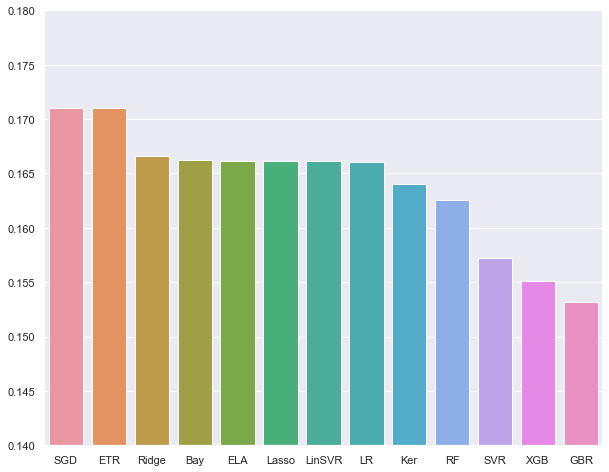

In [281]:
%matplotlib inline
train_model_res = [('LR',0.166064), ('Lasso',0.166158), ('Ridge', 0.166588),
                   ('RF', 0.162602), ('SVR', 0.157234),('GBR',0.153165),
                   ('LinSVR',0.166154),('ELA', 0.166161),('SGD', 0.171032),
                   ('Bay', 0.166213), ('Ker', 0.164012),
                   ('XGB',0.155096), ('ETR',0.171032)] # ETR为Extra Tree Regressor
train_model_res_sorted = sorted(train_model_res, key = lambda elem:elem[1], reverse = True)
trainres_x = [item[0] for item in train_model_res_sorted]
trainres_y = [item[1] for item in train_model_res_sorted]

plt.figure(figsize=(10, 8))
d = sns.barplot(trainres_x, trainres_y)
d.set(ylim = (0.14,0.18))
plt.show()

根据模型比较结果，我们考虑将RF，SVR，GBR，KER，XGB这五个模型进行集成，试图得到更好的结果

## 模型集成

In [242]:
LR_ = LinearRegression()
Lasso_ = Lasso(alpha=0.0006, max_iter=10000)
Ridge_ = Ridge(alpha=35)
RF_ = RandomForestRegressor(max_depth=7,n_estimators=360, min_samples_split= 3,
                                min_weight_fraction_leaf=0.0,min_samples_leaf = 2, 
                                max_features ='auto',min_impurity_decrease= 0.0)
SVR_ = SVR(kernel='rbf',gamma= 'scale', C = 0.75)
GBR_ = GradientBoostingRegressor(loss='huber',n_estimators= 100,
                                     min_samples_leaf=1, min_samples_split=2,
                                     learning_rate=0.1,max_depth=3, alpha=0.9)
LinSVR_ = LinearSVR(max_iter=45000, epsilon = 0.15)
ELA_ = ElasticNet(alpha = 0.0012, l1_ratio = 0.6)
SGD_ = SGDRegressor(alpha = 0.08, l1_ratio = 0.3, tol = 1e-4, max_iter = 10000)
BAY_ = BayesianRidge(alpha_1=1e-07, lambda_1 = 1e-05, alpha_2 = 1e-05, lambda_2 = 1e-07)
KER_ = KernelRidge(alpha = 0.3, kernel = 'polynomial', degree = 3,coef0 = 1)
XGBR_ = XGBRegressor(learning_rate=0.1, n_estimators= 425, 
                         seed= 0, max_depth= 3, min_child_weight= 2, 
                         subsample=0.9, colsample_bytree=0.6,gamma= 0.155374, 
                         reg_alpha= 0.06, reg_lambda=0.075)
ETR_ = ExtraTreesRegressor(max_depth=13,min_samples_leaf = 1,
                          max_features = "sqrt",random_state=10,
                          min_samples_split = 35)
# 模型数组
models_ = [LR_, Lasso_, Ridge_, RF_, SVR_, GBR_, LinSVR_, ELA_, SGD_, BAY_, KER_, XGBR_, ETR_]
names_ = ["LR",  "Lasso","Ridge", "RF",  "SVR", "GBR", "LinSVR", "ELA", "SGD","BAY", "KER","Xgb","Extra"]

### Weight Average方法

In [203]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        # 每个model变成训练后的model
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [251]:
# assign weights based on their gridsearch score
w1 = 0.05
w2 = 0.15
w3 = 0.3
w4 = 0.1
w5 = 0.4

In [252]:
# 将RF，SVR，GBR，KER，XGB这五个模型进行集成
weight_avg = AverageWeight(mod = [RF_, SVR_, GBR_, KER_, XGBR_],weight=[w1,w2,w3,w4,w5])

In [253]:
rmse_cv(weight_avg,X_scale,y)

array([0.14833549, 0.16664293, 0.15231328, 0.14384152, 0.14844008])

In [254]:
rmse_cv(weight_avg,X_scale,y).mean()

0.15204446795027474

### Stacking方法

In [215]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [257]:
stack_model = stacking(mod=[RF_, SVR_, GBR_, KER_, XGBR_],meta_model=LR_)

In [258]:
import warnings 
warnings.filterwarnings("ignore")
res = rmse_cv(stack_model,X_scale,y)
print(res.mean())

0.15298820268325147


### 模型比较

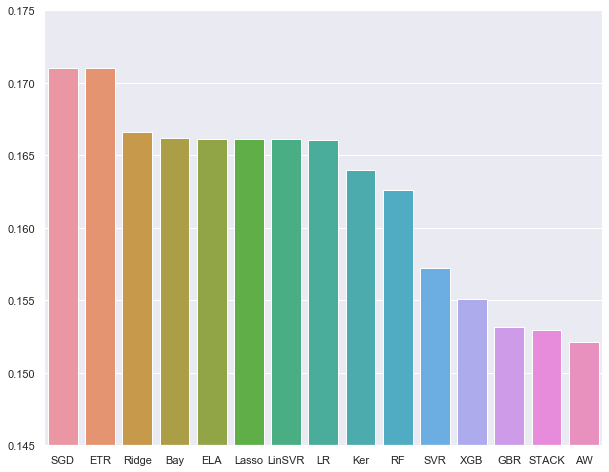

In [280]:
import matplotlib.pyplot as plt
%matplotlib inline
train_model_res = [('LR',0.166064), ('Lasso',0.166158), ('Ridge', 0.166588),
                   ('RF', 0.162602), ('SVR', 0.157234),('GBR',0.153165),
                   ('LinSVR',0.166154),('ELA', 0.166161),('SGD', 0.171032),
                   ('Bay', 0.166213), ('Ker', 0.164012),
                   ('XGB',0.155096), ('ETR',0.171032),
                   ('AW', 0.152100),('STACK', 0.152988)] # ETR为Extra Tree Regressor
train_model_res_sorted = sorted(train_model_res, key = lambda elem:elem[1], reverse = True)
trainres_x = [item[0] for item in train_model_res_sorted]
trainres_y = [item[1] for item in train_model_res_sorted]


plt.figure(figsize=(10, 8))
d = sns.barplot(trainres_x, trainres_y)
d.set(ylim = (0.145,0.175))
plt.show()